In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, TruncatedSVD

from data_processing import process
from density_anomaly import run_hdbscan_anomaly
from reconstruction import (
    build_autoencoder,
    compute_autoencoder_error,
    compute_pca_error,
)

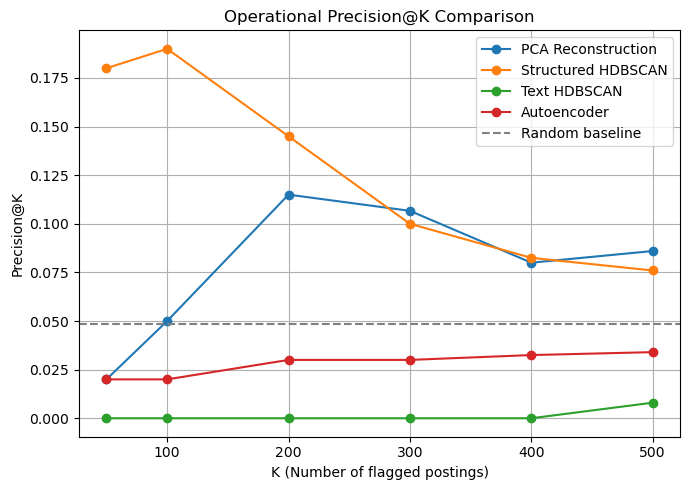

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def precision_at_k(y_true, scores, k):
    topk_idx = np.argsort(scores)[-k:]
    return y_true[topk_idx].mean()
df=pd.read_csv("results/fast_tuning/data_with_anomaly_scores.csv")  
y=df["fraudulent"].values
# Ground truth
y = df["fraudulent"].values
df["score_text_hdbscan"] = df["anomaly_text_hdbscan_mcs30_ms10_svd150"]
df["score_struct_hdbscan"] = df["anomaly_struct_hdbscan_mcs30_ms10"]
df["score_pca_recon"] = df["anomaly_pca_recon_100"]
df["score_autoencoder"] = df["anomaly_autoencoder_ld16"]
MODELS = {
    "PCA Reconstruction": "score_pca_recon",
    "Structured HDBSCAN": "score_struct_hdbscan",
    "Text HDBSCAN": "score_text_hdbscan",
    "Autoencoder": "score_autoencoder",
}

# K values to evaluate
K_VALUES = [50, 100, 200, 300, 400, 500]

plt.figure(figsize=(7, 5))

for name, col in MODELS.items():
    scores = df[col].values
    precisions = [
        precision_at_k(y, scores, k) for k in K_VALUES
    ]
    plt.plot(K_VALUES, precisions, marker="o", label=name)

# Baseline: random precision = fraud rate
plt.axhline(
    y.mean(),
    linestyle="--",
    color="gray",
    label="Random baseline",
)

plt.xlabel("K (Number of flagged postings)")
plt.ylabel("Precision@K")
plt.title("Operational Precision@K Comparison")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [7]:
df[["score_struct_hdbscan", "score_text_hdbscan", "score_pca_recon", "score_autoencoder"]]

,score_struct_hdbscan,score_text_hdbscan,score_pca_recon,score_autoencoder
0,0.023220,0.000000,0.082129,0.830305
1,0.002055,0.016848,0.240192,0.716102
2,0.289180,0.044208,0.008738,0.030646
3,0.000000,0.008162,0.045931,0.190357
4,0.295222,0.000000,0.047895,0.174908
...,...,...,...,...
17875,0.009001,0.059137,0.096142,0.497862
17876,0.004035,0.010249,0.226912,0.495221
17877,0.000000,0.080758,0.024798,0.039412
17878,0.046903,0.374536,0.410536,1.153924


In [8]:
MODELS = {
    "Structured HDBSCAN": "score_struct_hdbscan",
    "Text HDBSCAN": "score_text_hdbscan",
    "PCA Baseline": "score_pca_recon",
    "Autoencoder": "score_autoencoder",
}

In [9]:
score_cols = [
    "score_pca_recon",
    "score_struct_hdbscan",
    "score_text_hdbscan",
    "score_autoencoder",
]

desc_stats = df[score_cols].describe().T
desc_stats["median"] = df[score_cols].median()

desc_stats = desc_stats[
    ["mean", "std", "median", "min", "max"]
]

desc_stats

,mean,std,median,min,max
score_pca_recon,0.109531,0.108620,0.078066,0.005412,1.468533
score_struct_hdbscan,0.083636,0.170181,0.015238,0.000000,0.979122
score_text_hdbscan,0.212000,0.204596,0.179886,0.000000,0.970271
score_autoencoder,0.365741,0.397509,0.253239,0.009910,4.994428


hat you should observe (and say)

Structured HDBSCAN
→ low mean, small std → conservative anomaly assignment

Text HDBSCAN
→ near-zero mean → almost no anomaly signal

Autoencoder
→ higher mean, larger std → aggressive scoring

📌 Report sentence (you can use this verbatim)

Descriptive statistics reveal substantial differences in scoring behavior across models, with HDBSCAN-based approaches producing sparse, conservative anomaly scores and the autoencoder assigning higher anomaly scores more broadly.

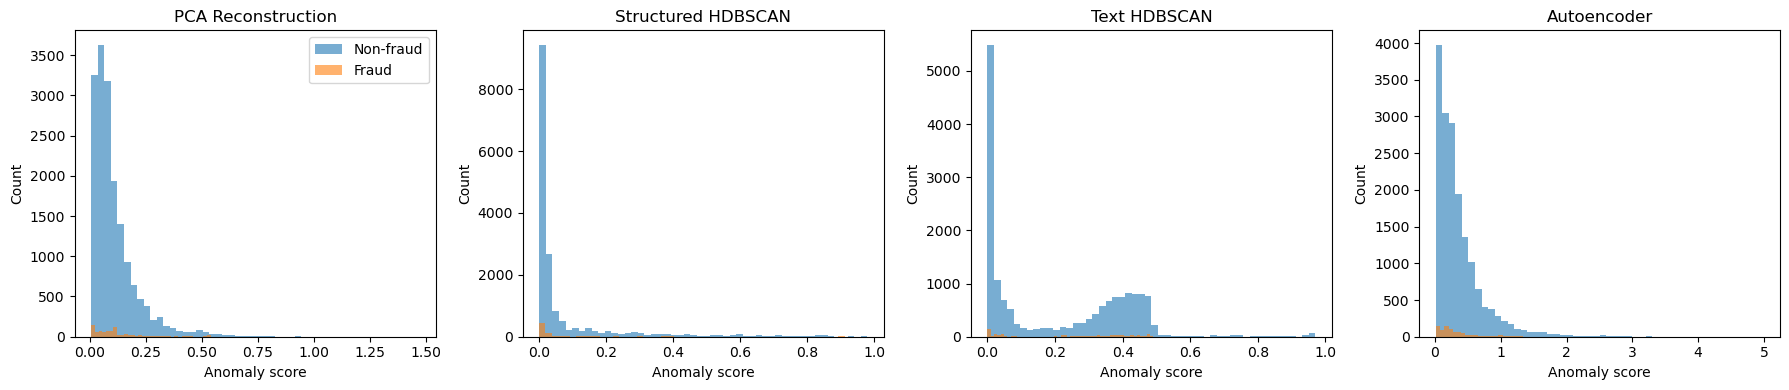

In [10]:
import matplotlib.pyplot as plt

models = {
    "PCA Reconstruction": "score_pca_recon",
    "Structured HDBSCAN": "score_struct_hdbscan",
    "Text HDBSCAN": "score_text_hdbscan",
    "Autoencoder": "score_autoencoder",
}

fig, axes = plt.subplots(1, 4, figsize=(18, 4))

for ax, (name, col) in zip(axes, models.items()):
    ax.hist(df.loc[df["fraudulent"] == 0, col],
            bins=50, alpha=0.6, label="Non-fraud")
    ax.hist(df.loc[df["fraudulent"] == 1, col],
            bins=50, alpha=0.6, label="Fraud")

    ax.set_title(name)
    ax.set_xlabel("Anomaly score")
    ax.set_ylabel("Count")

axes[0].legend()
plt.tight_layout()
plt.show()


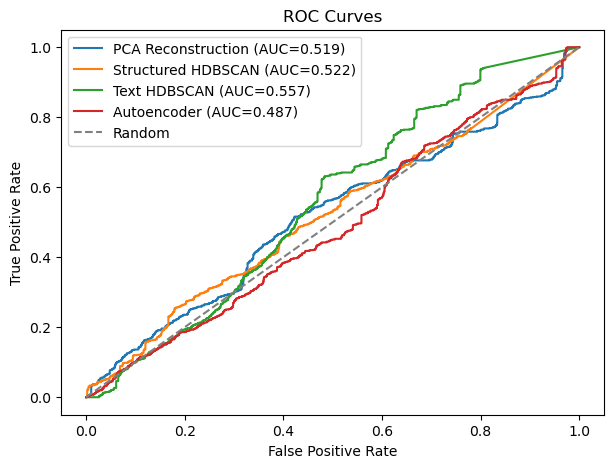

In [11]:
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(7, 5))

for name, col in models.items():
    fpr, tpr, _ = roc_curve(df["fraudulent"], df[col])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.3f})")

plt.plot([0, 1], [0, 1],"--", color="gray" ,label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.show()


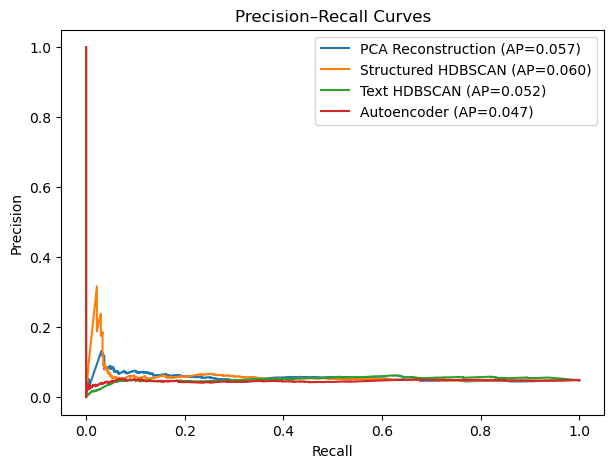

In [12]:
from sklearn.metrics import precision_recall_curve, average_precision_score

plt.figure(figsize=(7, 5))

for name, col in models.items():
    precision, recall, _ = precision_recall_curve(df["fraudulent"], df[col])
    ap = average_precision_score(df["fraudulent"], df[col])
    plt.plot(recall, precision, label=f"{name} (AP={ap:.3f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curves")
plt.legend()
plt.show()

While ROC–AUC values are modest across all models, precision–recall curves demonstrate improved ranking performance for structured HDBSCAN relative to reconstruction-based baselines.

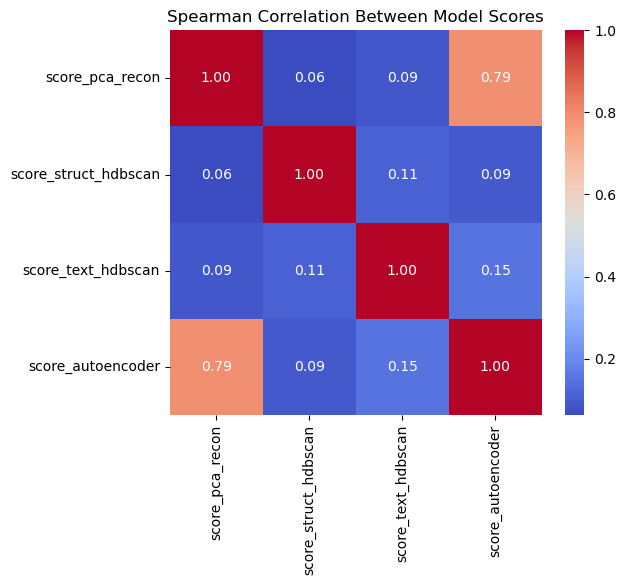

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Map raw column names to publication-ready labels
label_map = {
    "score_pca_recon": "PCA Reconstruction",
    "score_struct_hdbscan": "Structured HDBSCAN",
    "score_text_hdbscan": "Text HDBSCAN",
    "score_autoencoder": "Autoencoder Reconstruction",
}

# Compute Spearman correlation
corr = df[score_cols].corr(method="spearman")

# Rename rows and columns for display
corr = corr.rename(index=label_map, columns=label_map)

plt.figure(figsize=(6, 5))
sns.heatmap(
    corr,
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    square=True,
    cbar_kws={"label": "Spearman Correlation"}
)

plt.title("Spearman Rank Correlation Between Model Scores")
plt.tight_layout()
plt.show()


In [14]:
from sklearn.metrics import average_precision_score

def precision_at_k(y, scores, k):
    return y[np.argsort(scores)[-k:]].mean()

rows = []

for name, col in models.items():
    rows.append({
        "Model": name,
        "ROC-AUC": auc(*roc_curve(df["fraudulent"], df[col])[:2]),
        "AP": average_precision_score(df["fraudulent"], df[col]),
        "Precision@500": precision_at_k(df["fraudulent"].values, df[col].values, 500),
        "Mean score": df[col].mean(),
        "Std score": df[col].std(),
    })

comparison_df = pd.DataFrame(rows)
comparison_df


,Model,ROC-AUC,AP,Precision@500,Mean score,Std score
0,PCA Reconstruction,0.518606,0.056686,0.086,0.109531,0.108620
1,Structured HDBSCAN,0.522274,0.060252,0.076,0.083636,0.170181
2,Text HDBSCAN,0.556556,0.051690,0.008,0.212000,0.204596
3,Autoencoder,0.487246,0.046528,0.034,0.365741,0.397509


In [15]:
from sklearn.metrics import average_precision_score

def precision_at_k(y, scores, k):
    return y[np.argsort(scores)[-k:]].mean()

rows = []

for name, col in models.items():
    rows.append({
        "Model": name,
        "ROC-AUC": auc(*roc_curve(df["fraudulent"], df[col])[:2]),
        "AP": average_precision_score(df["fraudulent"], df[col]),
        "Precision@500": precision_at_k(df["fraudulent"].values, df[col].values, 500),
        "Mean score": df[col].mean(),
        "Std score": df[col].std(),
    })

comparison_df = pd.DataFrame(rows)
comparison_df


,Model,ROC-AUC,AP,Precision@500,Mean score,Std score
0,PCA Reconstruction,0.518606,0.056686,0.086,0.109531,0.108620
1,Structured HDBSCAN,0.522274,0.060252,0.076,0.083636,0.170181
2,Text HDBSCAN,0.556556,0.051690,0.008,0.212000,0.204596
3,Autoencoder,0.487246,0.046528,0.034,0.365741,0.397509


In [16]:
import numpy as np
from sklearn.metrics import average_precision_score

K = 500
results = []

for name, col in MODELS.items():
    scores = df[col].values
    topk = np.argsort(scores)[-K:]

    precision_k = y[topk].mean()
    recall_k = y[topk].sum() / y.sum()
    ap = average_precision_score(y, scores)

    results.append({
        "Model": name,
        "Average Precision": ap,
        "Precision@500": precision_k,
        "Recall@500": recall_k,
    })

results_df = pd.DataFrame(results)
results_df

,Model,Average Precision,Precision@500,Recall@500
0,Structured HDBSCAN,0.060252,0.076,0.043880
1,Text HDBSCAN,0.051690,0.008,0.004619
2,PCA Baseline,0.056686,0.086,0.049654
3,Autoencoder,0.046528,0.034,0.019630


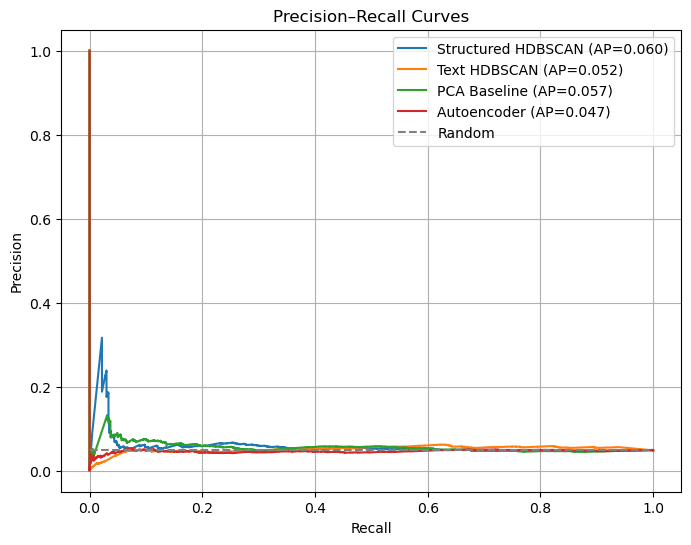

In [17]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

plt.figure(figsize=(8, 6))

for name, col in MODELS.items():
    scores = df[col].values
    precision, recall, _ = precision_recall_curve(y, scores)
    ap = average_precision_score(y, scores)

    plt.plot(recall, precision, label=f"{name} (AP={ap:.3f})")

# Random baseline
base_rate = y.mean()
plt.hlines(base_rate, 0, 1, linestyles="dashed", colors="gray", label="Random")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curves")
#plt.xlim(0.01, 1.0)   # avoid AE spike dominating
plt.legend()
plt.grid(True)
plt.show()


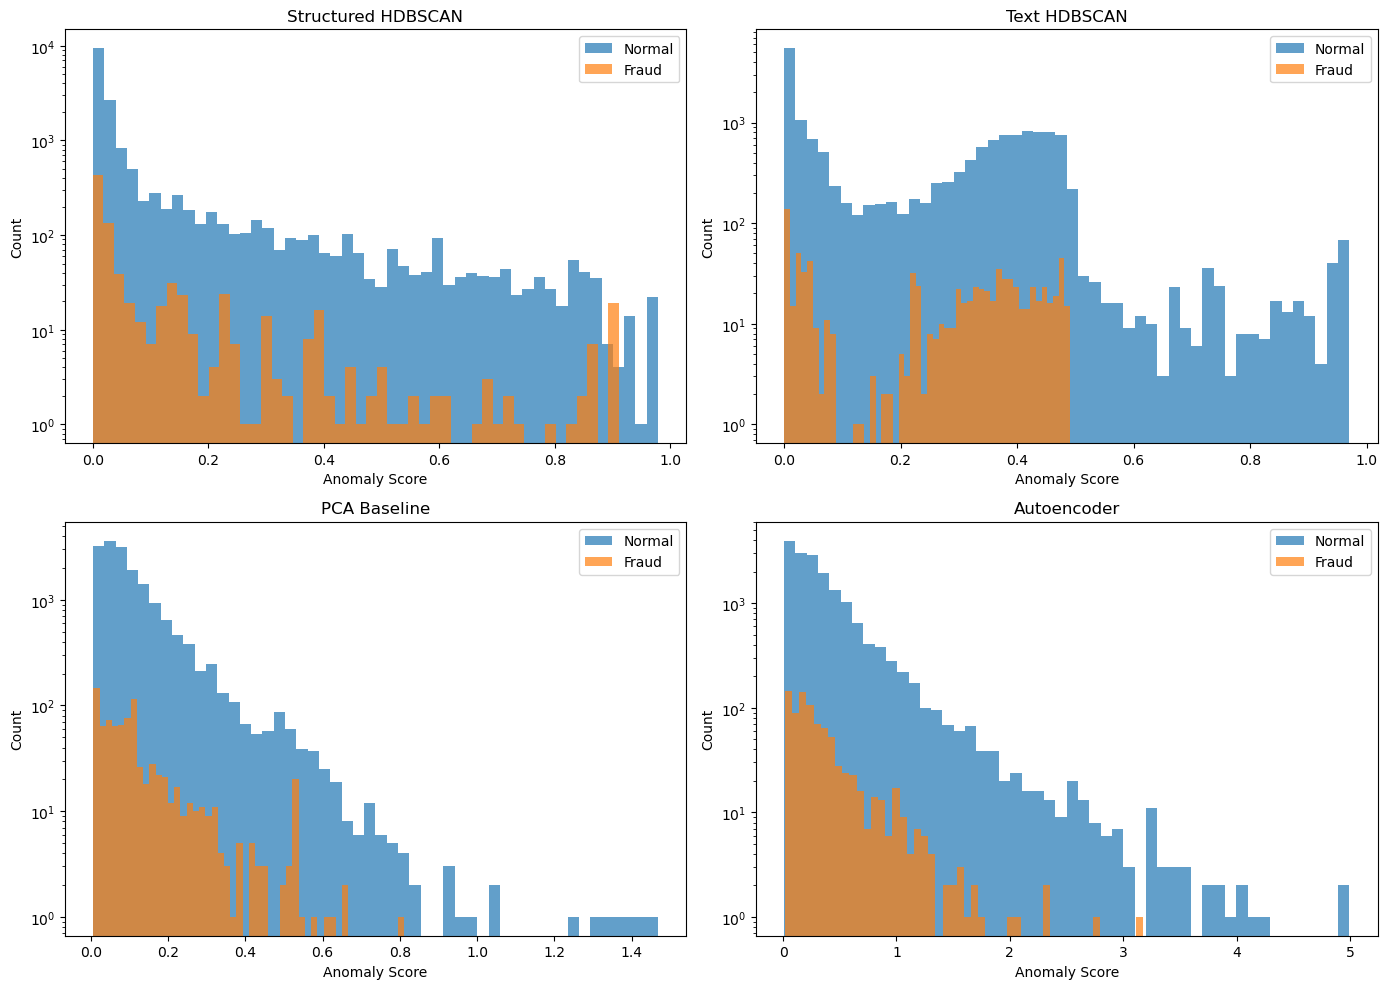

In [18]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

bins = 50

for ax, (name, col) in zip(axes, MODELS.items()):
    ax.hist(df.loc[y == 0, col], bins=bins, alpha=0.7, label="Normal")
    ax.hist(df.loc[y == 1, col], bins=bins, alpha=0.7, label="Fraud")
    ax.set_title(name)
    ax.set_xlabel("Anomaly Score")
    ax.set_ylabel("Count")
    ax.legend()
    ax.set_yscale("log")

plt.tight_layout()
plt.show()


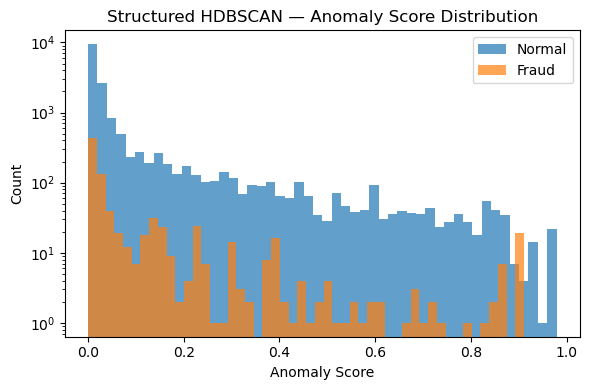

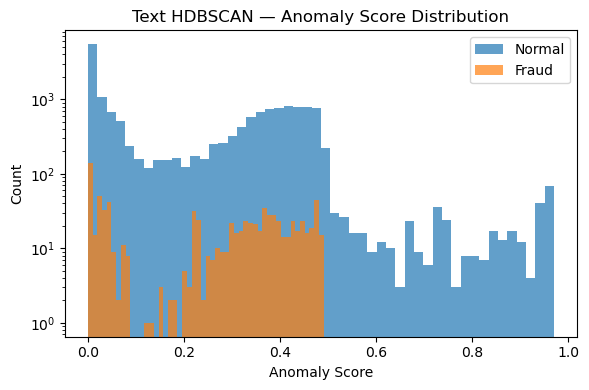

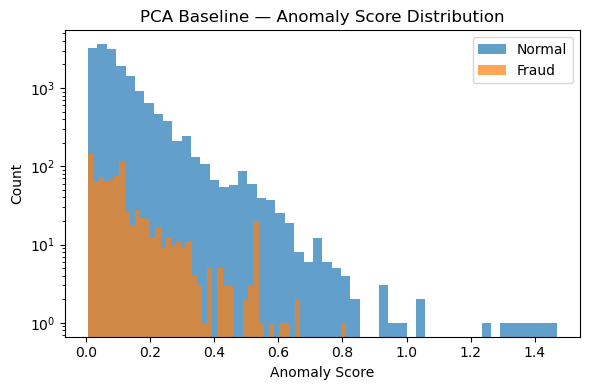

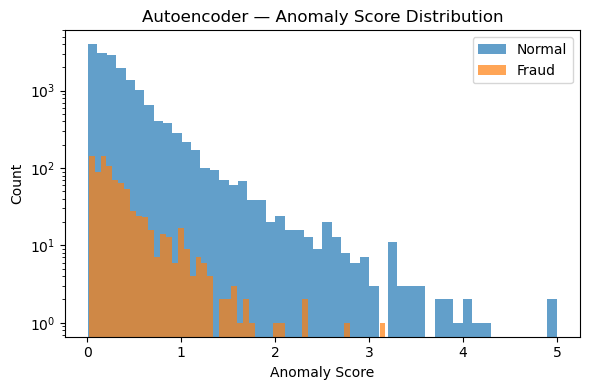

In [19]:
import matplotlib.pyplot as plt

bins = 50

for name, col in MODELS.items():
    plt.figure(figsize=(6, 4))

    plt.hist(
        df.loc[y == 0, col],
        bins=bins,
        alpha=0.7,
        label="Normal",
    )
    plt.hist(
        df.loc[y == 1, col],
        bins=bins,
        alpha=0.7,
        label="Fraud",
    )

    plt.yscale("log")
    plt.xlabel("Anomaly Score")
    plt.ylabel("Count")
    plt.title(f"{name} — Anomaly Score Distribution")
    plt.legend()

    plt.tight_layout()
    plt.show()


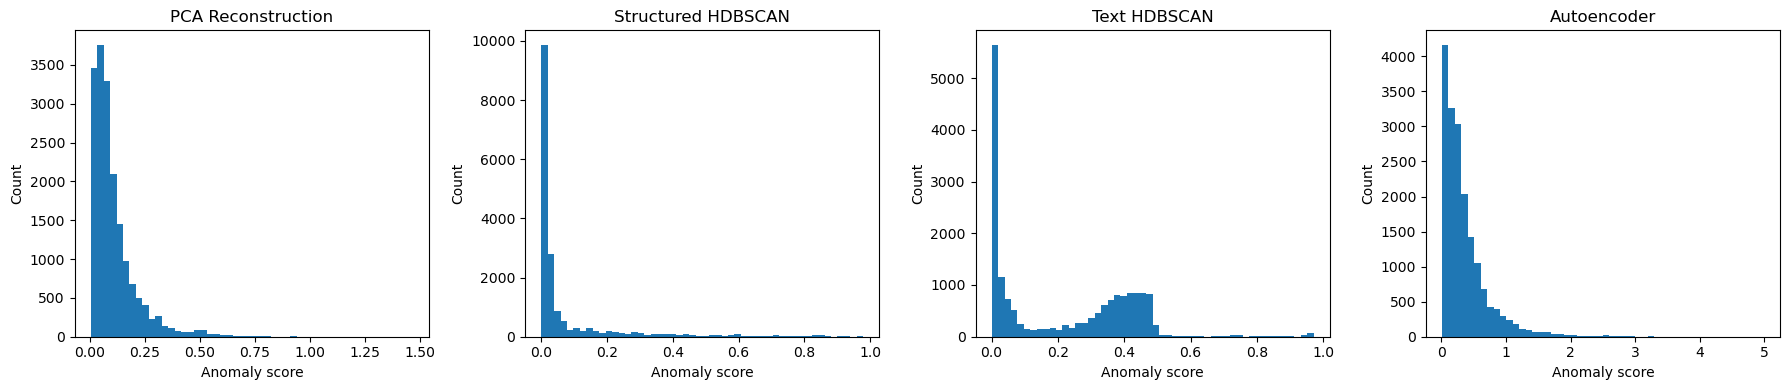

In [20]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 4, figsize=(18, 4))

cols = [
    ("score_pca_recon", "PCA Reconstruction"),
    ("score_struct_hdbscan", "Structured HDBSCAN"),
    ("score_text_hdbscan", "Text HDBSCAN"),
    ("score_autoencoder", "Autoencoder"),
]

for ax, (col, title) in zip(axes, cols):
    ax.hist(df[col], bins=50)
    ax.set_title(title)
    ax.set_xlabel("Anomaly score")
    ax.set_ylabel("Count")

plt.tight_layout()
plt.show()


In [21]:
import numpy as np
import pandas as pd
from sklearn.metrics import average_precision_score, roc_auc_score

y = df["fraudulent"].values

MODELS = {
    "PCA Reconstruction": "score_pca_recon",
    "Structured HDBSCAN": "score_struct_hdbscan",
    "Text HDBSCAN": "score_text_hdbscan",
    "Autoencoder": "score_autoencoder",
}

K = 1000

rows = []

for name, col in MODELS.items():
    scores = df[col].values
    topk = np.argsort(scores)[-K:]

    precision_k = y[topk].mean()
    recall_k = y[topk].sum() / y.sum()
    ap = average_precision_score(y, scores)
    auc = roc_auc_score(y, scores)

    rows.append({
        "Model": name,
        "Average Precision": ap,
        "Precision@500": precision_k,
        "Recall@500": recall_k,
        "ROC–AUC": auc,
    })

table1 = pd.DataFrame(rows).sort_values("Average Precision", ascending=False)
table1


,Model,Average Precision,Precision@500,Recall@500,ROC–AUC
1,Structured HDBSCAN,0.060252,0.054,0.062356,0.522274
0,PCA Reconstruction,0.056686,0.071,0.081986,0.518606
2,Text HDBSCAN,0.051690,0.023,0.026559,0.556556
3,Autoencoder,0.046528,0.046,0.053118,0.487246


In [22]:
table2 = pd.DataFrame([
    {"Model": "PCA Reconstruction", "Selected Parameters": "n_components = 100"},
    {"Model": "Structured HDBSCAN", "Selected Parameters": "min_cluster_size = 30, min_samples = 10"},
    {"Model": "Text HDBSCAN", "Selected Parameters": "min_cluster_size = 30, min_samples = 10, SVD = 150"},
    {"Model": "Autoencoder", "Selected Parameters": "latent_dim = 16"},
])

table2


,Model,Selected Parameters
0,PCA Reconstruction,n_components = 100
1,Structured HDBSCAN,"min_cluster_size = 30, min_samples = 10"
2,Text HDBSCAN,"min_cluster_size = 30, min_samples = 10, SVD =..."
3,Autoencoder,latent_dim = 16


In [23]:
table3 = pd.DataFrame([
    {"Statistic": "Total samples", "Value": len(df)},
    {"Statistic": "Fraud cases", "Value": int(df["fraudulent"].sum())},
    {"Statistic": "Non-fraud cases", "Value": int((df["fraudulent"] == 0).sum())},
    {"Statistic": "Fraud rate", "Value": df["fraudulent"].mean()},
])

table3


,Statistic,Value
0,Total samples,17880.000000
1,Fraud cases,866.000000
2,Non-fraud cases,17014.000000
3,Fraud rate,0.048434


In [24]:
from sklearn.metrics import confusion_matrix

confusion_tables = {}

for name, col in MODELS.items():
    scores = df[col].values

    # Binary prediction: top-K are flagged as anomalies
    y_pred = np.zeros_like(y)
    topk_idx = np.argsort(scores)[-K:]
    y_pred[topk_idx] = 1

    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()

    confusion_tables[name] = pd.DataFrame(
        [[tp, fp], [fn, tn]],
        index=["Actual Fraud", "Actual Non-Fraud"],
        columns=["Predicted Fraud", "Predicted Non-Fraud"],
    )

confusion_tables


{'PCA Reconstruction':                   Predicted Fraud  Predicted Non-Fraud
 Actual Fraud                   71                  929
 Actual Non-Fraud              795                16085,
 'Structured HDBSCAN':                   Predicted Fraud  Predicted Non-Fraud
 Actual Fraud                   54                  946
 Actual Non-Fraud              812                16068,
 'Text HDBSCAN':                   Predicted Fraud  Predicted Non-Fraud
 Actual Fraud                   23                  977
 Actual Non-Fraud              843                16037,
 'Autoencoder':                   Predicted Fraud  Predicted Non-Fraud
 Actual Fraud                   46                  954
 Actual Non-Fraud              820                16060}

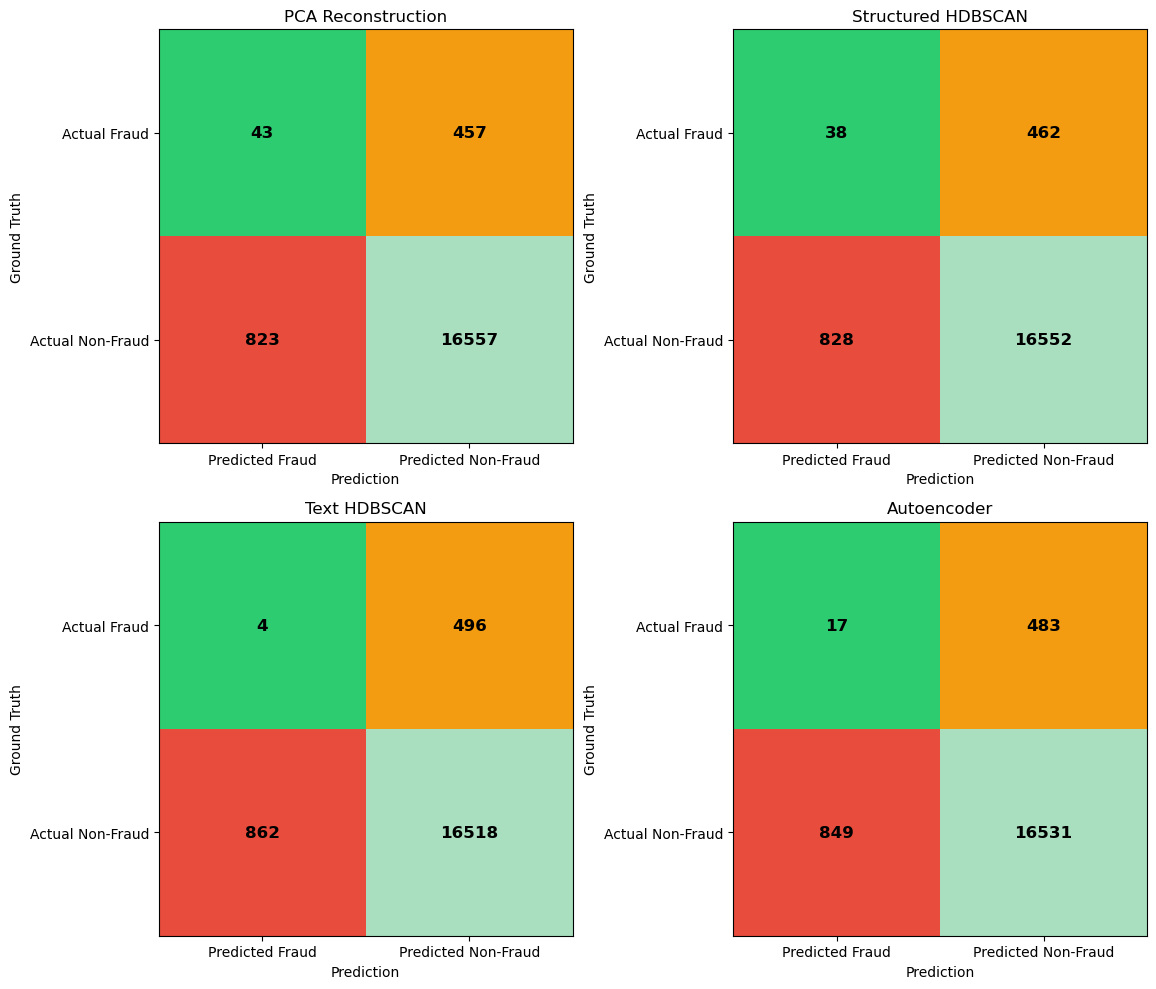

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from matplotlib.colors import ListedColormap

y = df["fraudulent"].values

MODELS = {
    "PCA Reconstruction": "score_pca_recon",
    "Structured HDBSCAN": "score_struct_hdbscan",
    "Text HDBSCAN": "score_text_hdbscan",
    "Autoencoder": "score_autoencoder",
}

K = 500

# Custom colormap: [TP, FP, FN, TN]
cmap = ListedColormap([
    "#2ecc71",  # green (TP)
    "#f39c12",  # orange (FP)
    "#e74c3c",  # red (FN)
    "#a9dfbf",  # light green (TN)
])

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for ax, (name, col) in zip(axes, MODELS.items()):
    scores = df[col].values

    # Binary prediction: top-K flagged
    y_pred = np.zeros_like(y)
    topk_idx = np.argsort(scores)[-K:]
    y_pred[topk_idx] = 1

    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()

    # Arrange as:
    # [[TP, FP],
    #  [FN, TN]]
    cm = np.array([[tp, fp],
                   [fn, tn]])

    # Color matrix encoding cell type
    color_idx = np.array([[0, 1],
                          [2, 3]])

    ax.imshow(color_idx, cmap=cmap)

    # Annotate counts
    for i in range(2):
        for j in range(2):
            ax.text(
                j,
                i,
                cm[i, j],
                ha="center",
                va="center",
                fontsize=12,
                fontweight="bold",
                color="black",
            )

    ax.set_title(name)
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(["Predicted Fraud", "Predicted Non-Fraud"])
    ax.set_yticklabels(["Actual Fraud", "Actual Non-Fraud"])
    ax.set_xlabel("Prediction")
    ax.set_ylabel("Ground Truth")

plt.tight_layout()
plt.show()


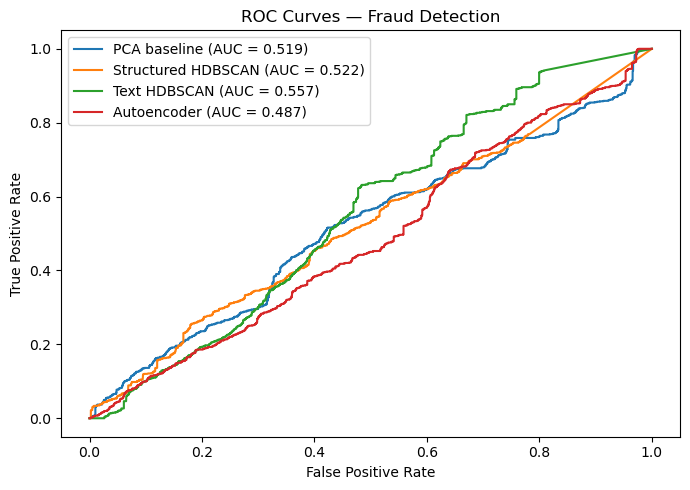

In [26]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(7, 5))

models = {
    "PCA baseline": df["score_pca_recon"].values,
    "Structured HDBSCAN": df["score_struct_hdbscan"].values,
    "Text HDBSCAN": df["score_text_hdbscan"].values,
    "Autoencoder": df["score_autoencoder"].values,
}

for name, scores in models.items():
    fpr, tpr, _ = roc_curve(y, scores)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.3f})")


plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves — Fraud Detection")
plt.legend()
plt.tight_layout()
plt.show()


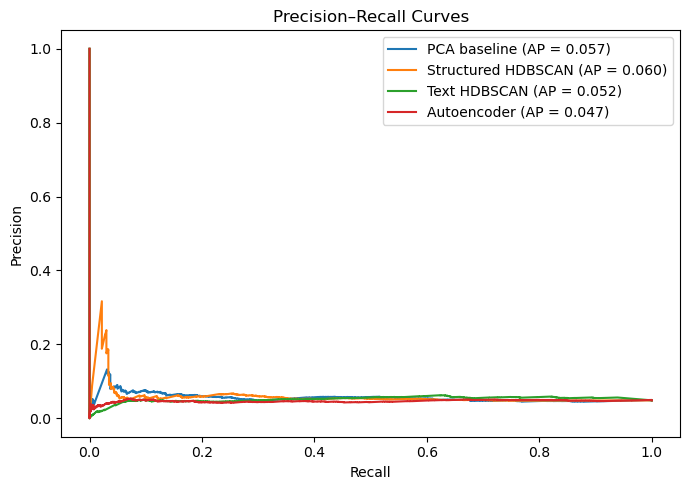

In [27]:
from sklearn.metrics import precision_recall_curve, average_precision_score

plt.figure(figsize=(7, 5))

for name, scores in models.items():
    precision, recall, _ = precision_recall_curve(y, scores)
    ap = average_precision_score(y, scores)
    plt.plot(recall, precision, label=f"{name} (AP = {ap:.3f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curves")
plt.legend()
plt.tight_layout()
plt.show()


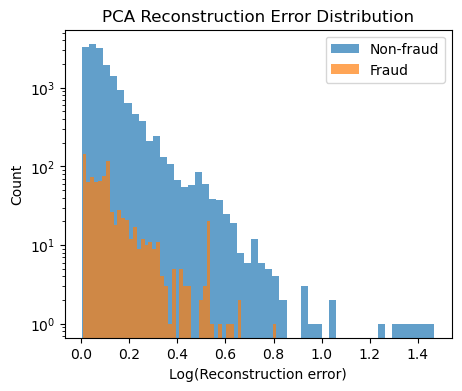

In [28]:
plt.figure(figsize=(5,4))
plt.hist(df.loc[y==0, "score_pca_recon"], bins=50, alpha=0.7, label="Non-fraud")
plt.hist(df.loc[y==1, "score_pca_recon"], bins=50, alpha=0.7, label="Fraud")
plt.yscale("log")
plt.xlabel("Log(Reconstruction error)")
plt.ylabel("Count")
plt.title("PCA Reconstruction Error Distribution")
plt.legend()
plt.show()


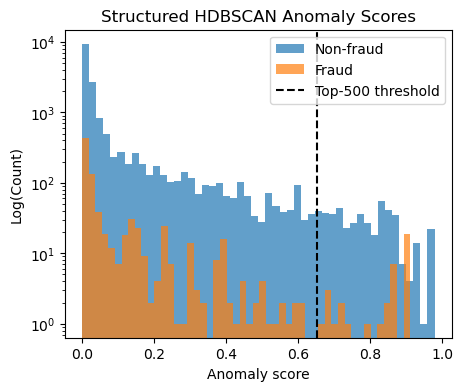

In [29]:
scores = df["score_struct_hdbscan"].values
threshold = np.sort(scores)[-500]

plt.figure(figsize=(5,4))
plt.hist(df.loc[y==0, "score_struct_hdbscan"], bins=50, alpha=0.7, label="Non-fraud")
plt.hist(df.loc[y==1, "score_struct_hdbscan"], bins=50, alpha=0.7, label="Fraud")
plt.axvline(threshold, color="black", linestyle="--", label="Top-500 threshold")
plt.yscale("log")
plt.xlabel("Anomaly score")
plt.ylabel("Log(Count)")
plt.title("Structured HDBSCAN Anomaly Scores")
plt.legend()
plt.show()


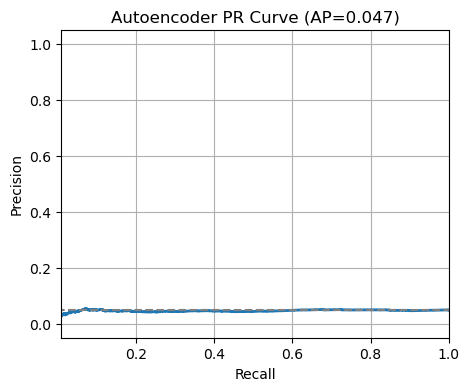

In [30]:
from sklearn.metrics import precision_recall_curve, average_precision_score

scores = df["score_autoencoder"].values
precision, recall, _ = precision_recall_curve(y, scores)
ap = average_precision_score(y, scores)

plt.figure(figsize=(5,4))
plt.plot(recall, precision, linewidth=2)
plt.hlines(y.mean(), 0, 1, linestyles="dashed", colors="gray")
plt.xlim(0.01, 1)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Autoencoder PR Curve (AP={ap:.3f})")
plt.grid(True)
plt.show()
